In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt

from pandas.tseries.offsets import BDay
from tqdm import tqdm

pd.set_option("display.max_columns", None)

PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

In [2]:
def get_truncated_df(merge_df, columns, year_column_name=None, low=0.01, high=0.99):
    merge_df_copy = merge_df.copy()
    if year_column_name == None:
        for column in columns: 
            _1pct, _99pct = merge_df_copy[column].quantile(q=low), merge_df_copy[column].quantile(q=high)
            merge_df_copy[column].where((merge_df_copy[column] < _99pct) & (merge_df_copy[column] > _1pct), math.nan, inplace=True)
    else: 
        merge_df_list = []
        merge_year_df_list = [[year, merge_year_df] for year, merge_year_df in merge_df_copy.groupby(year_column_name)]
        for year, merge_year_df in tqdm(merge_year_df_list):
            for column in columns: 
                _1pct, _99pct = merge_year_df[column].quantile(q=low), merge_year_df[column].quantile(q=high)
                merge_year_df[column].where(~((merge_year_df[column] > _99pct) | (merge_year_df[column] < _1pct)), math.nan, inplace=True)
            merge_df_list.append(merge_year_df)
        merge_df_copy = pd.concat(merge_df_list)
    
    return merge_df_copy

def get_boj_quintiles_conditional(sue_df_boj_merged, suffix=None, quantiles=5):
    sue_df_boj_merged_nd = sue_df_boj_merged[['sedol', 'yr_qtr_index', 'boj_share_shares']].drop_duplicates()
    sue_df_boj_merged_nd_list = []
    for index, df in tqdm(sue_df_boj_merged_nd.groupby('yr_qtr_index')): 
        try:
            df['boj_share_shares_quantiles_'+suffix] = pd.qcut(df['boj_share_shares'], quantiles, labels=False)
        except: 
            df['boj_share_shares_quantiles_'+suffix] = [math.nan for i in range(len(df))]

        sue_df_boj_merged_nd_list.append(df)

    sue_df_boj_merged_nd = pd.concat(sue_df_boj_merged_nd_list)

    sue_df_boj_merged = pd.merge(sue_df_boj_merged, 
                                 sue_df_boj_merged_nd, 
                                 on=['sedol', 'yr_qtr_index', 'boj_share_shares'])
    return sue_df_boj_merged

In [3]:
dm_df = pd.read_stata(PATH+'regression_files\dta_files\dm_regression.dta')

In [4]:
dm_df = dm_df[dm_df['date'] >= pd.to_datetime('2010-12-15')]

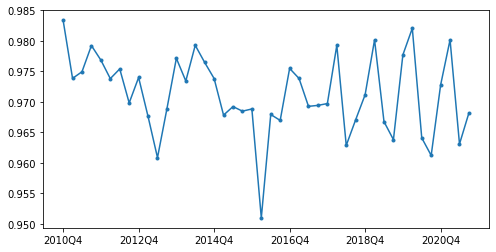

In [5]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.set_xticks([0, 8, 16, 24, 32, 40, 48, 56])
ax.plot(dm_df.groupby(['yr_qtr_str'])['dm_short_1'].mean(), marker='.')

In [6]:
dm_df = get_boj_quintiles_conditional(dm_df, suffix='nk', quantiles=5)

100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 267.72it/s]


[]

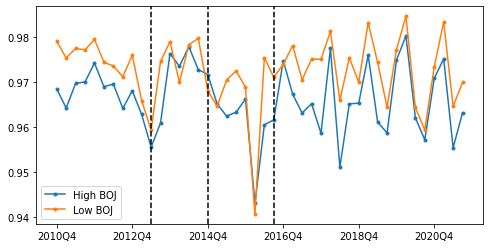

In [11]:
dm_df_high = dm_df[dm_df['boj_share_shares_quantiles_nk'].isin([4])]
dm_df_low = dm_df[dm_df['boj_share_shares_quantiles_nk'].isin([0])]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.set_xticks([0, 8, 16, 24, 32, 40, 48, 56])

ax.plot(dm_df_high.groupby(['yr_qtr_str'])['dm_short_1'].mean(), marker='.', label='High BOJ')
ax.plot(dm_df_low.groupby(['yr_qtr_str'])['dm_short_1'].mean(), marker='.', label='Low BOJ')

ax.axvline('2013Q2', ls='--', color='k')
ax.axvline('2014Q4', ls='--', color='k')
ax.axvline('2016Q3', ls='--', color='k')

ax.legend()
plt.plot()